# Performance of SVMs in Large Datasets

The main idea of this document is to evaluate and analyze the behavior of support vector machines in large datasets and implement some alternative methods such as Cascade SVMs, Bagging-Like SVMs adn Stepwise Baggind SVMs. 

_(Some other methods can be added)_

In [26]:
#Loading all the required libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import scipy as sc
import random as rd
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn import datasets,svm,metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn.datasets import load_digits
from sklearn import preprocessing
import matplotlib.pylab as plt

## MNIST Digits Dataset

Let's use the MNIST dataset as a first example and let's check the size of the dataset and the dimension of the input space.

In [27]:
#Loading train and test datasets
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
print('The shape of train images is ' + np.str(train_images.shape))
print('The shape of test images is ' + np.str(test_images.shape))

The shape of train images is (60000, 28, 28)
The shape of test images is (10000, 28, 28)


In [3]:
#Normalizing pixels, so the take values from 0 to 1
train_images, test_images = train_images/255.0, test_images/255.0

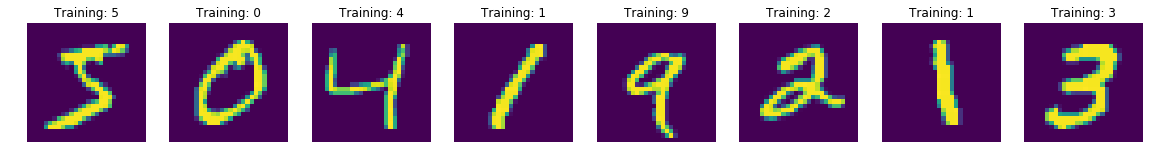

In [15]:
#Let's visualizate the digits (the first n digits)
n = 8
plt.figure(figsize=(20,10))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.axis('off')
    plt.imshow(train_images[i,:].reshape((28,28)))
    plt.title('Training: %i' % train_labels[i]) 

In [5]:
#How many labels there are? 10: the digits from 0 to 9
size_labels = len(np.unique(train_labels)) ; size_labels

10

In [6]:
#We have to reshape the data (extend the pixels in one arrange)
train_images_svm = train_images.reshape(len(train_images), 28*28)
test_images_svm = test_images.reshape(len(test_images), 28*28)
print('The shape of train images is ' + np.str(train_images_svm.shape))
print('The shape of test images is ' + np.str(test_images_svm.shape))

The shape of train images is (60000, 784)
The shape of test images is (10000, 784)


In [25]:
#Function which objective is to plot in a fancy way the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    #print(cm)

    fig, ax = plt.subplots(figsize = (10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## SVMs Performance and Analysis

The main idea of this section is to see the behavior of regular SVMs in diferent subsamples of the original data.

In [7]:
#We generate a random order of the sample 
random_order = rd.sample(range(len(train_images_svm)), len(train_images_svm))
np.sort(random_order)

array([    0,     1,     2, ..., 59997, 59998, 59999])

In [8]:
#Pick a number multiple of len(train_images_svm)=60000
size_subsample = 1000
total_of_subsamples = np.int(len(train_images_svm)/size_subsample) ; total_of_subsamples

60

In [9]:
#We pick one subsample of size size_subsample and evaluate it doing SVMs
number_of_subsample = rd.randint(0,total_of_subsamples-1) 
first = number_of_subsample*size_subsample
last = (number_of_subsample+1)*size_subsample
values = random_order[first:last]

train_subsample_images = train_images_svm[values,:]
train_subsample_labels = train_labels[values]
train_subsample_images.shape

(1000, 784)

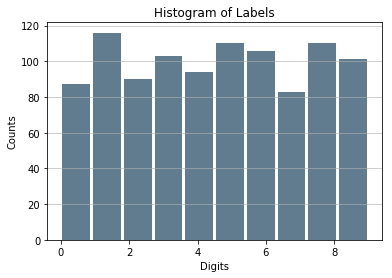

In [10]:
#Histogram of the labels. The idea is to veirfy that the digits are balanced
train_subsample_labels_pd = pd.DataFrame(train_subsample_labels)
train_subsample_labels_pd.plot.hist(grid=False, bins=10, rwidth=0.9, color='#607c8e', legend=None)
plt.title('Histogram of Labels')
plt.xlabel('Digits')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [11]:
#This auxiliar function returns zero if the two values are equal and one if not
def mistake(x,y):
    if x == y:
        return 0
    else:
        return 1
mistake_vectorized = np.vectorize(mistake)

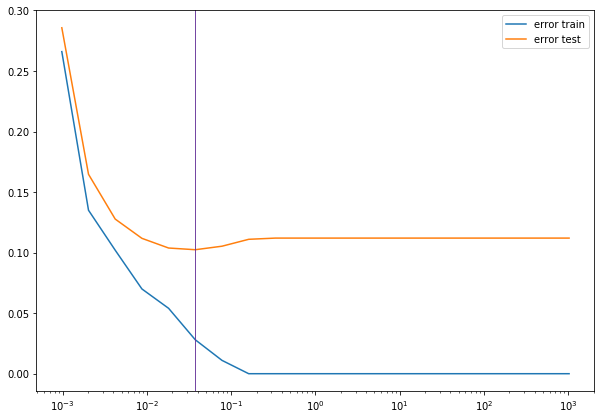

The minimum error in the test dataset is 0.1024 with C = 0.03750320998681571


In [20]:
#Let's evlauate different C's 
c = np.logspace(-10, 10, 20, base=2)
error_train=[]
error_test=[]
for i in range(len(c)):
    classifier = svm.SVC(C = c[i], gamma =0.0001, kernel='linear')
    classifier.fit(train_subsample_images, train_subsample_labels)
    predicted_test = classifier.predict(test_images_svm)
    predicted_train = classifier.predict(train_subsample_images)
    test_score = np.sum(mistake_vectorized(predicted_test, test_labels))/len(test_labels)
    train_score = np.sum(mistake_vectorized(predicted_train, train_subsample_labels))/len(train_subsample_labels)
    error_train.append(train_score)
    error_test.append(test_score)
    #print(i)
    
#Let's plot the train and test errors and pick the C that minimizes the test error    
plt.figure(figsize=(10,7))
plt.plot(c,error_train,label="error train")
plt.plot(c,error_test,label="error test")
plt.axvline(x=c[np.argmin(error_test)],linewidth=0.9,color="rebeccapurple")
plt.xscale("log")
plt.legend()
plt.show()
print('The minimum error in the test dataset is ' + np.str(np.min(error_test)) + ' with C = ' 
      + np.str(c[np.argmin(error_test)]))

In [ ]:
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plot_confusion_matrix(test_labels, predictions_reshaped, classes=np.sort(np.unique(train_labels)),
                      title='Confusion matrix (Without Normalization)')

plt.show()
# Plot normalized confusion matrix
plot_confusion_matrix(test_labels, predictions_reshaped, classes=np.sort(np.unique(train_labels)),
                      normalize=True, title='Normalized Confusion Matrix')

plt.show()

In [24]:
clf = svm.SVC(C = c[np.argmin(error_test)], gamma=0.0001, kernel='linear')
clf.fit(train_subsample_images, train_subsample_labels)
#Now predict the value of the digit on the second half:
expected = test_labels
predicted = clf.predict(test_images_svm)
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))

Classification report for classifier SVC(C=0.03750320998681571, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.92      0.98      0.95      1135
           2       0.93      0.86      0.90      1032
           3       0.90      0.87      0.88      1010
           4       0.89      0.89      0.89       982
           5       0.83      0.84      0.84       892
           6       0.91      0.95      0.93       958
           7       0.94      0.89      0.91      1028
           8       0.89      0.83      0.86       974
           9       0.85      0.89      0.87      1009

   micro avg       0.90      0.90      0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg  